In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from scipy import stats
import folium
import geopandas as gpd
from geopy.geocoders import Nominatim
from sklearn.cluster import DBSCAN, KMeans, MiniBatchKMeans, SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import LabelEncoder
import collections.abc
from collections.abc import MutableSequence 

import xgboost
import shap
shap.initjs()

In [42]:
data['VEHICLE TYPE CODE 2'].value_counts(dropna=False)

VEHICLE TYPE CODE 2
Sedan                                  387185
NaN                                    380397
Station Wagon/Sport Utility Vehicle    312743
PASSENGER VEHICLE                      295974
SPORT UTILITY / STATION WAGON          130211
                                        ...  
DSNY                                        1
CRWZK                                       1
NYCFIREDEP                                  1
U-TRU                                       1
MARSH ,OPE                                  1
Name: count, Length: 1757, dtype: int64

In [2]:
data = pd.read_csv("Cleaned data/Cleaned_Data.csv", index_col=0, parse_dates=['CRASH DATE'])
data['YEAR'] = data['CRASH DATE'].dt.year
data['MONTH'] = data['CRASH DATE'].dt.month
data['HOUR'] = data['CRASH TIME'].apply(lambda i:int(i.split(':')[0]))

In [3]:
encoders = {}
data_clustering = data.drop(columns = ['CRASH DATE', 'CRASH TIME', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME', 'COLLISION_ID'])
data_clustering = data_clustering[data_clustering['NUMBER OF PERSONS INJURED'] > 0]
for col in data_clustering.columns:
    if data_clustering[col].dtype == 'O':
        col_encoder = LabelEncoder()
        data_clustering[col] = col_encoder.fit_transform(data_clustering[col])
        encoders[col] = [col_encoder]
    else:
        encoders[col] = []
    scaler = StandardScaler()
    data_clustering[col] = scaler.fit_transform(np.array(data_clustering[col]).reshape(-1, 1))
    encoders[col].append(scaler)

In [4]:
data_clustering.dtypes

BOROUGH                          float64
ZIP CODE                         float64
LATITUDE                         float64
LONGITUDE                        float64
NUMBER OF PERSONS INJURED        float64
NUMBER OF PERSONS KILLED         float64
NUMBER OF PEDESTRIANS INJURED    float64
NUMBER OF PEDESTRIANS KILLED     float64
NUMBER OF CYCLIST INJURED        float64
NUMBER OF CYCLIST KILLED         float64
NUMBER OF MOTORIST INJURED       float64
NUMBER OF MOTORIST KILLED        float64
CONTRIBUTING FACTOR VEHICLE 1    float64
CONTRIBUTING FACTOR VEHICLE 2    float64
CONTRIBUTING FACTOR VEHICLE 3    float64
CONTRIBUTING FACTOR VEHICLE 4    float64
CONTRIBUTING FACTOR VEHICLE 5    float64
VEHICLE TYPE CODE 1              float64
VEHICLE TYPE CODE 2              float64
VEHICLE TYPE CODE 3              float64
VEHICLE TYPE CODE 4              float64
VEHICLE TYPE CODE 5              float64
YEAR                             float64
MONTH                            float64
DATE            

In [5]:
data_clustering[['LONGITUDE', 'LATITUDE']].describe()

LONGITUDE      LATITUDE
count  4.537610e+05  4.537610e+05
mean  -6.022710e-14 -2.904148e-14
std    1.000001e+00  1.000001e+00
min   -3.932219e+00 -2.754967e+00
25%   -5.843207e-01 -7.005999e-01
50%   -6.146785e-02 -1.017067e-01
75%    6.025303e-01  6.041344e-01
max    3.002660e+00  2.817290e+00

In [6]:
data_clustering.loc[data_clustering['ZIP CODE'].isna(),'ZIP CODE'] = -1
data_clustering.isna().sum().sum()

0

In [7]:
scores = {}
print("Begin")

for yr in data_clustering['YEAR'].unique():
    print(yr)
    data_yr = data_clustering[data_clustering['YEAR']==yr]
    scores[yr] = []
    for k in range(1, 10):
        print(k, " clusters", end = "; ")
        scores[yr].append([])
        for seed in range(3):
            print(seed)
            kmeans = MiniBatchKMeans(
                n_clusters=k,
                max_iter=25,
                n_init=1,
                random_state=seed,
                batch_size=10240
            )
            kmeans.fit(data_yr)
            y_kmeans = kmeans.predict(data_yr)
            # Plot
            scores[yr][k-1].append(kmeans.inertia_)

Begin
0.9329294975103221
1  clusters; 0
1
2
2  clusters; 0
1
2
3  clusters; 0
1
2
4  clusters; 0
1
2
5  clusters; 0
1
2
6  clusters; 0
1
2
7  clusters; 0
1
2
8  clusters; 0
1
2
9  clusters; 0
1
2
1.230356334138899
1  clusters; 0
1
2
2  clusters; 0
1
2
3  clusters; 0
1
2
4  clusters; 0
1
2
5  clusters; 0
1
2
6  clusters; 0
1
2
7  clusters; 0
1
2
8  clusters; 0
1
2
9  clusters; 0
1
2
0.33807582425316823
1  clusters; 0
1
2
2  clusters; 0
1
2
3  clusters; 0
1
2
4  clusters; 0
1
2
5  clusters; 0
1
2
6  clusters; 0
1
2
7  clusters; 0
1
2
8  clusters; 0
1
2
9  clusters; 0
1
2
1.5277831707674758
1  clusters; 0
1
2
2  clusters; 0
1
2
3  clusters; 0
1
2
4  clusters; 0
1
2
5  clusters; 0
1
2
6  clusters; 0
1
2
7  clusters; 0
1
2
8  clusters; 0
1
2
9  clusters; 0
1
2
0.6355026608817452
1  clusters; 0
1
2
2  clusters; 0
1
2
3  clusters; 0
1
2
4  clusters; 0
1
2
5  clusters; 0
1
2
6  clusters; 0
1
2
7  clusters; 0
1
2
8  clusters; 0
1
2
9  clusters; 0
1
2
1.8252100073960529
1  clusters; 0
1
2
2  clu

In [8]:
scores

{0.9329294975103221: [[896147.8923933506,
   896148.8096807458,
   896149.6853464798],
  [839472.7909644693, 821812.5234029513, 850898.7522452535],
  [788666.3868752653, 763399.1894786407, 808872.6381258948],
  [756840.4690069705, 740053.4337525469, 771225.077965281],
  [734062.1130335914, 723350.4839810475, 744201.9867976004],
  [664541.9741430428, 674136.3241240187, 682282.2207799566],
  [637219.2724506629, 670110.2864533806, 653462.6156835661],
  [620644.7593535631, 635177.4067524305, 640118.5891584068],
  [615286.3016881975, 629778.36606147, 626457.6397381037]],
 1.230356334138899: [[876392.6729846746, 876393.8464324471, 876394.2119101227],
  [824863.371794143, 821410.3599104442, 824259.5228055856],
  [774207.5762177998, 778585.2323534404, 768871.871321614],
  [748481.8595352484, 717421.0650654853, 741116.895664075],
  [726014.4239989343, 694000.6603980816, 711814.8560810671],
  [693528.0515592718, 675935.6916126347, 683730.8462427467],
  [654775.2636709515, 640250.3906398404, 6716

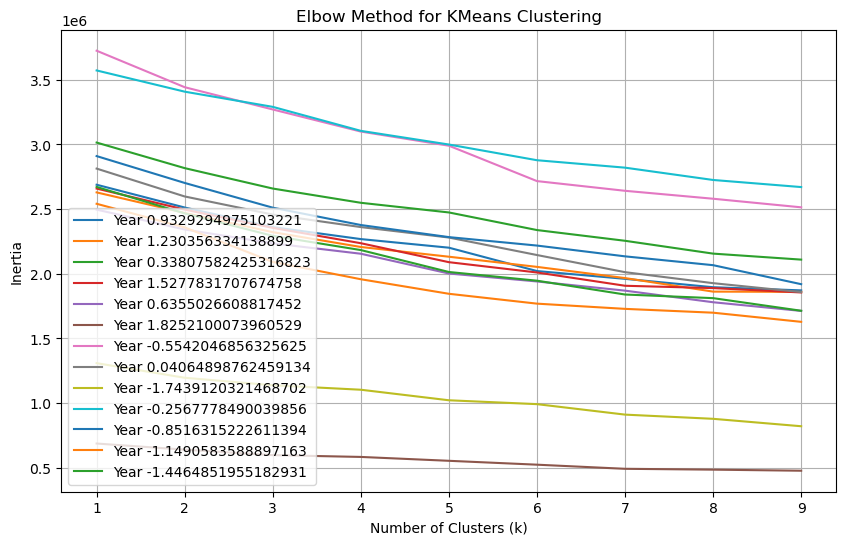

In [9]:
import matplotlib.pyplot as plt

# Initialize an empty list to store the inertias
inertias = []

# Initialize a list to store the years
years = []

# Iterate over the dictionary containing scores
for yr, score_list in scores.items():
    # Extract the inertias for the current year
    yr_inertias = [sum(score) for score in score_list]
    inertias.append(yr_inertias)
    years.append(yr)

# Plot the elbow method
plt.figure(figsize=(10, 6))
for i, yr_inertia in enumerate(inertias):
    plt.plot(range(1, 10), yr_inertia, label=f'Year {years[i]}')

plt.title('Elbow Method for KMeans Clustering')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.legend()
plt.grid(True)
plt.show()


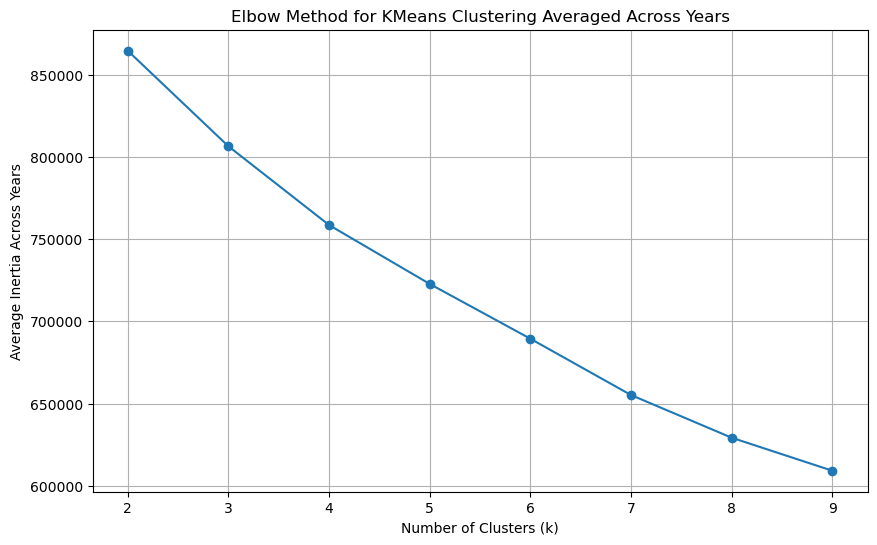

In [10]:
average_inertias_per_k = []

k_range = range(2, 10)

for k_index in k_range:
    all_inertias_for_k = []
    
    for year_inertias in scores.values():
        all_inertias_for_k.extend(year_inertias[k_index - 2])
    
    average_inertia = sum(all_inertias_for_k) / len(all_inertias_for_k)
    average_inertias_per_k.append(average_inertia)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(k_range, average_inertias_per_k, marker='o')

# Add titles and labels
plt.title('Elbow Method for KMeans Clustering Averaged Across Years')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Inertia Across Years')

# Show the plot
plt.grid(True)
plt.show()


In [11]:
kmeans = MiniBatchKMeans(
    n_clusters=5,
    max_iter=25,
    n_init=1,
    random_state=42,
    batch_size=10240
    )
kmeans.fit(data_clustering)
y_kmeans = kmeans.predict(data_clustering)

In [12]:
data_clustering['CLUSTER']=y_kmeans

In [13]:
cutoff = encoders['YEAR'][0].transform(np.array([2023]).reshape(-1, 1))[0][0]

In [14]:
X_train = data_clustering[data_clustering['YEAR']<cutoff].drop(columns=['CLUSTER'])
X_test = data_clustering[data_clustering['YEAR']>=cutoff].drop(columns=['CLUSTER'])
y_train = data_clustering[data_clustering['YEAR']<cutoff]['CLUSTER']
y_test = data_clustering[data_clustering['YEAR']>=cutoff]['CLUSTER']

In [15]:
d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)

In [16]:
X_test.shape

(48482, 26)

In [17]:
params = {
    "eta": 0.01,
    "objective": "multi:softprob",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "auc",
    "num_class": 5
}
model = xgboost.train(
    params,
    d_train,
    5000,
    evals=[(d_test, "test")],
    verbose_eval=100,
    early_stopping_rounds=20,
)

[0]	test-auc:0.99092
[100]	test-auc:0.99469
[200]	test-auc:0.99624
[300]	test-auc:0.99731
[400]	test-auc:0.99810
[500]	test-auc:0.99864
[600]	test-auc:0.99900
[700]	test-auc:0.99922
[800]	test-auc:0.99936
[900]	test-auc:0.99947
[1000]	test-auc:0.99954
[1100]	test-auc:0.99959
[1200]	test-auc:0.99963
[1300]	test-auc:0.99966
[1400]	test-auc:0.99969
[1500]	test-auc:0.99970
[1600]	test-auc:0.99972
[1700]	test-auc:0.99973
[1800]	test-auc:0.99975
[1900]	test-auc:0.99976
[2000]	test-auc:0.99976
[2100]	test-auc:0.99977
[2200]	test-auc:0.99978
[2300]	test-auc:0.99978
[2400]	test-auc:0.99979
[2500]	test-auc:0.99979
[2600]	test-auc:0.99980
[2700]	test-auc:0.99980
[2800]	test-auc:0.99980
[2900]	test-auc:0.99980
[3000]	test-auc:0.99981
[3100]	test-auc:0.99981
[3200]	test-auc:0.99981
[3287]	test-auc:0.99981


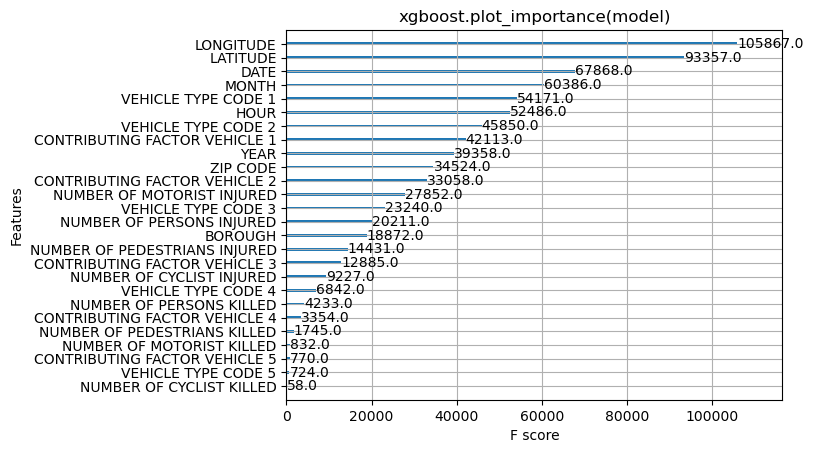

In [18]:
xgboost.plot_importance(model)
plt.title("xgboost.plot_importance(model)")
plt.show()

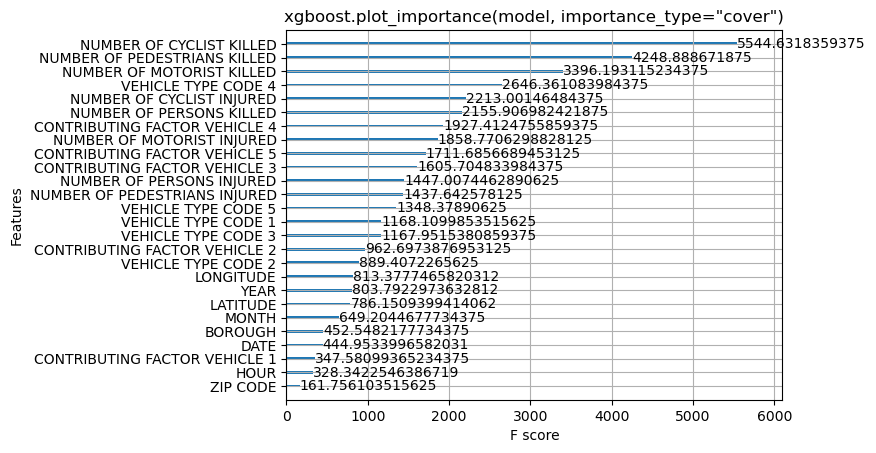

In [19]:
xgboost.plot_importance(model, importance_type="cover")
plt.title('xgboost.plot_importance(model, importance_type="cover")')
plt.show()

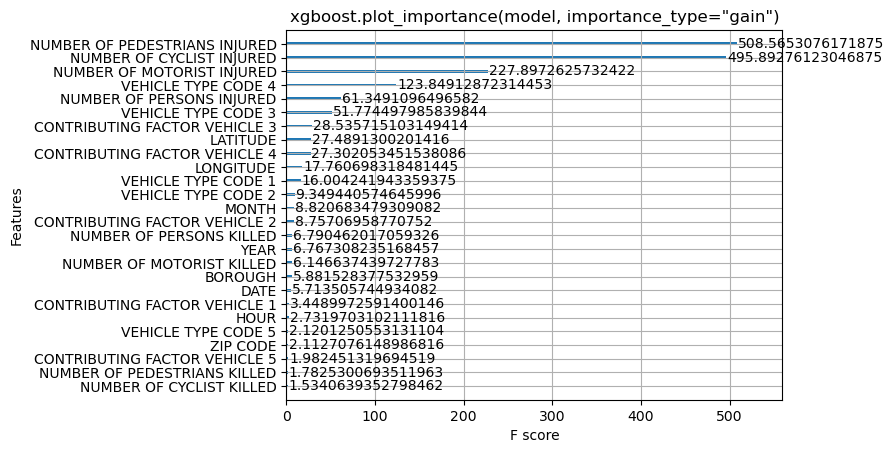

In [20]:
xgboost.plot_importance(model, importance_type="gain")
plt.title('xgboost.plot_importance(model, importance_type="gain")')
plt.show()


In [21]:
explainer = shap.TreeExplainer(model)

In [22]:
data_sample = data_clustering.sample(n=30000)
d_sample = xgboost.DMatrix(data_sample.drop(columns=['CLUSTER']), label=data_sample['CLUSTER'])

In [23]:
shap_values=explainer.shap_values(d_sample)

In [24]:
feature_names = np.array(data_sample.drop(columns=['CLUSTER']).columns)

In [25]:
shap.force_plot(
    explainer.expected_value[0], shap_values[:1000, :, 0], data_sample.drop(columns=['CLUSTER']).iloc[:1000]
)

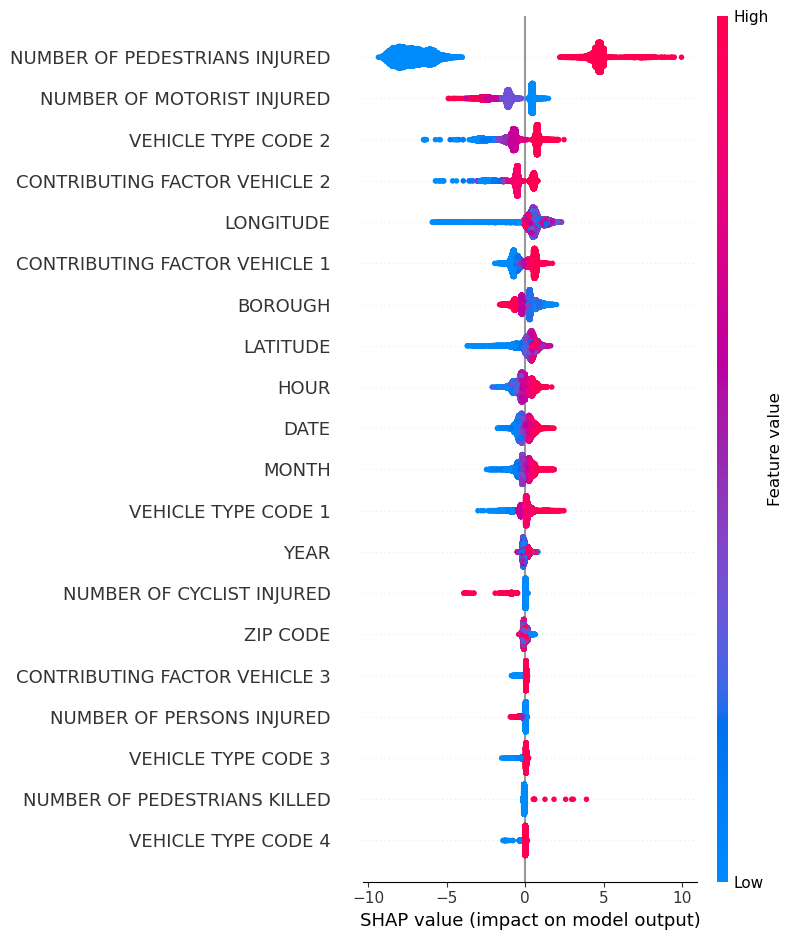

In [26]:
shap.summary_plot(shap_values[:,:,0], data_sample.drop(columns=['CLUSTER']))

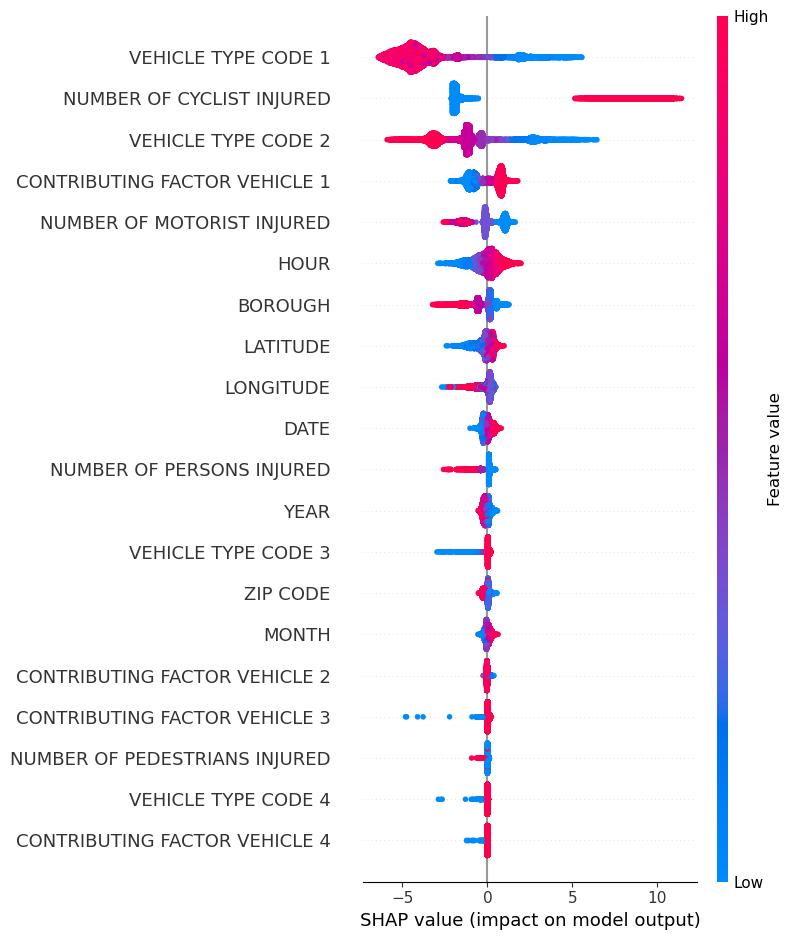

In [27]:
shap.summary_plot(shap_values[:,:,1], data_sample.drop(columns=['CLUSTER']))

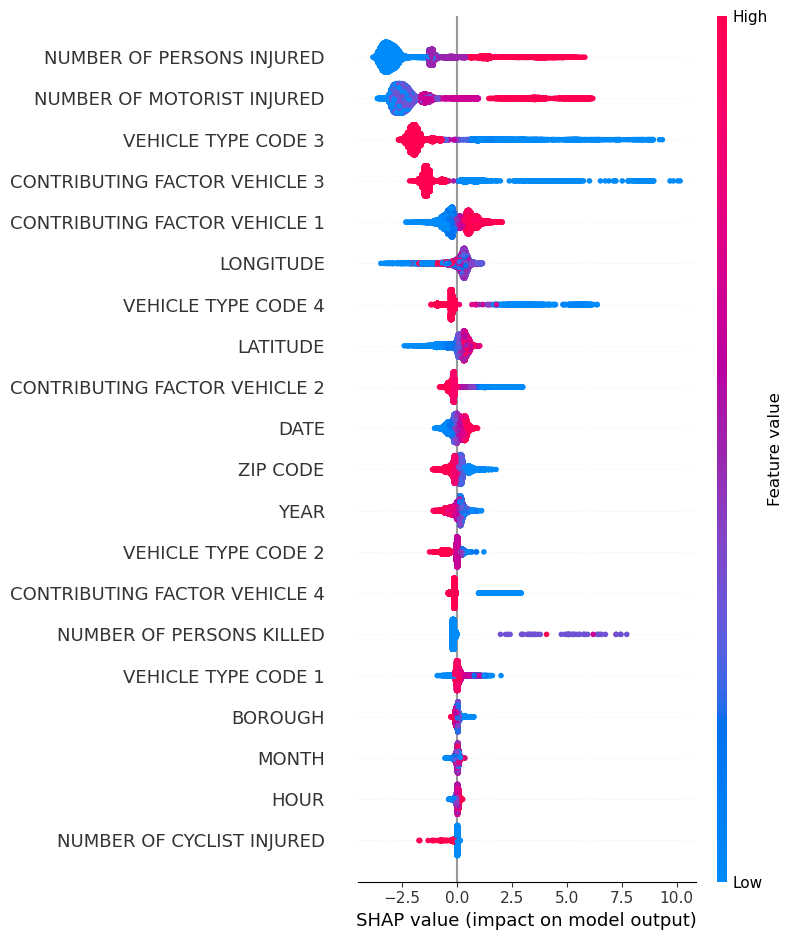

In [28]:
shap.summary_plot(shap_values[:,:,2], data_sample.drop(columns=['CLUSTER']))

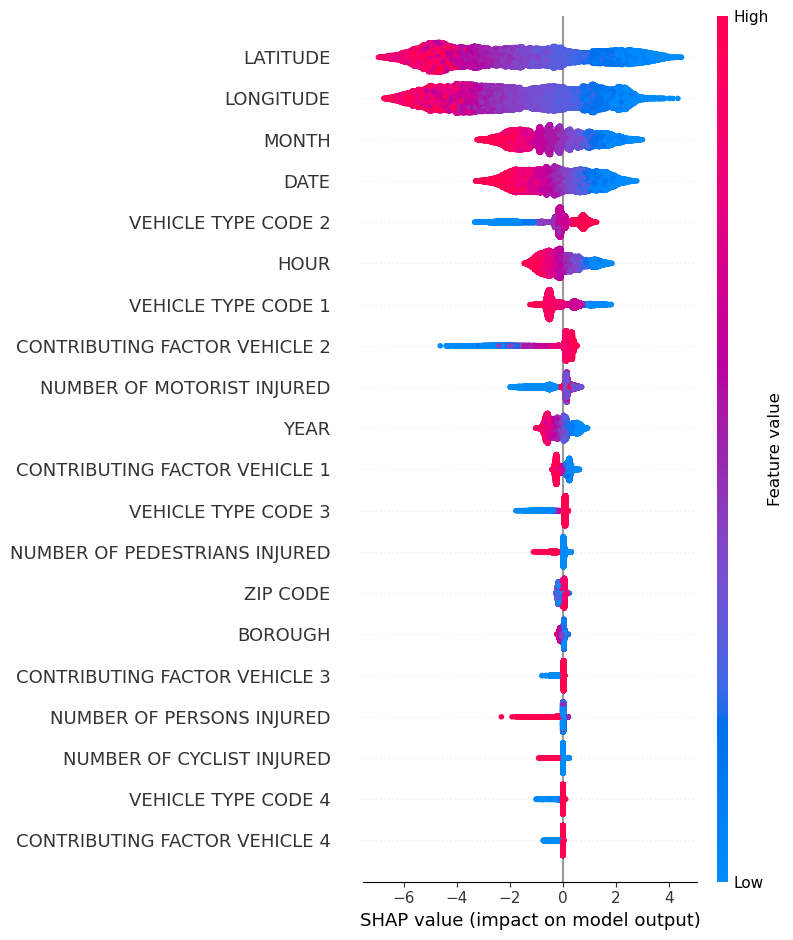

In [29]:
shap.summary_plot(shap_values[:,:,3], data_sample.drop(columns=['CLUSTER']))

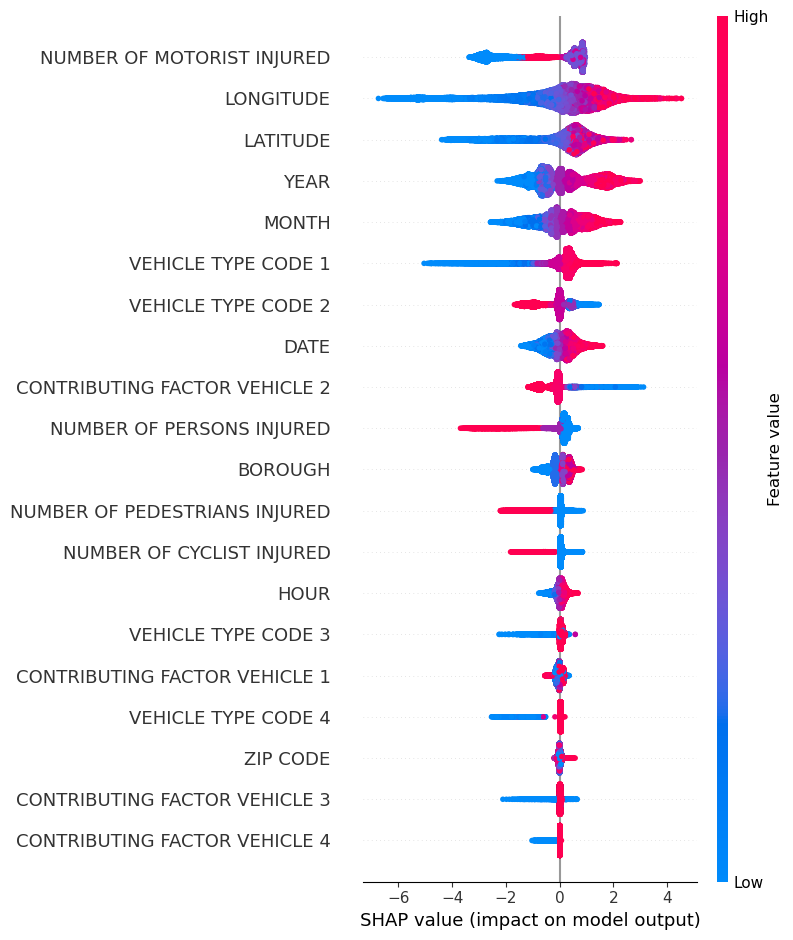

In [30]:
shap.summary_plot(shap_values[:,:,4], data_sample.drop(columns=['CLUSTER']))

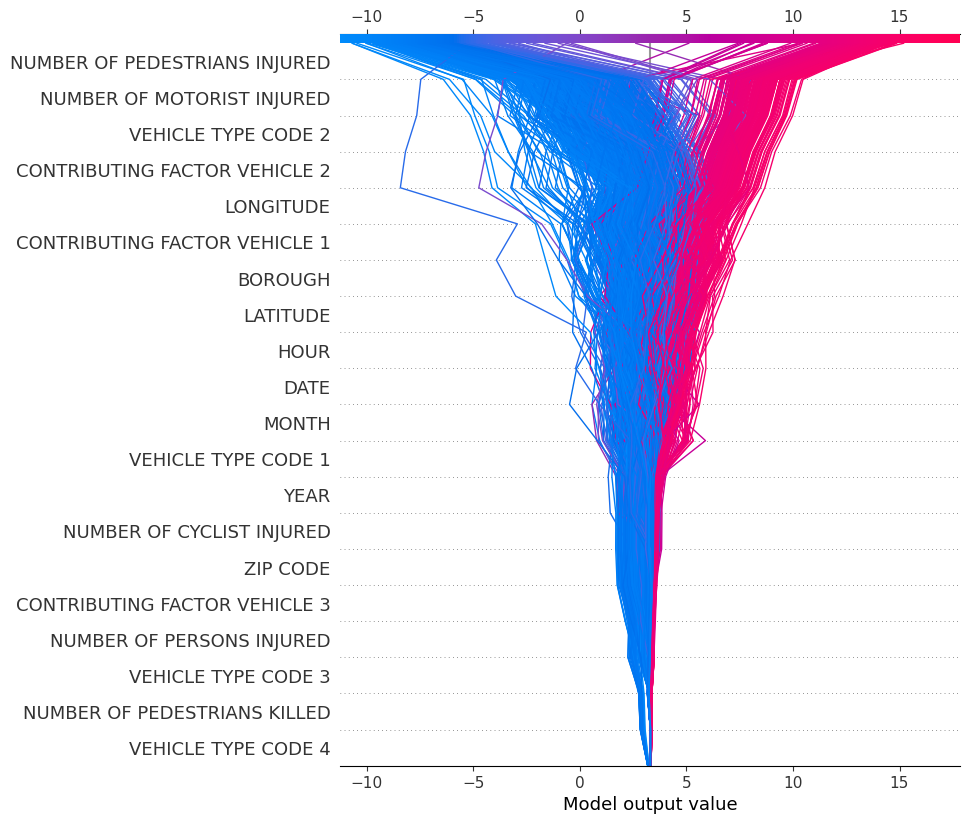

In [31]:
shap.decision_plot(explainer.expected_value[0], shap_values[:1000,:,0], feature_names=feature_names)

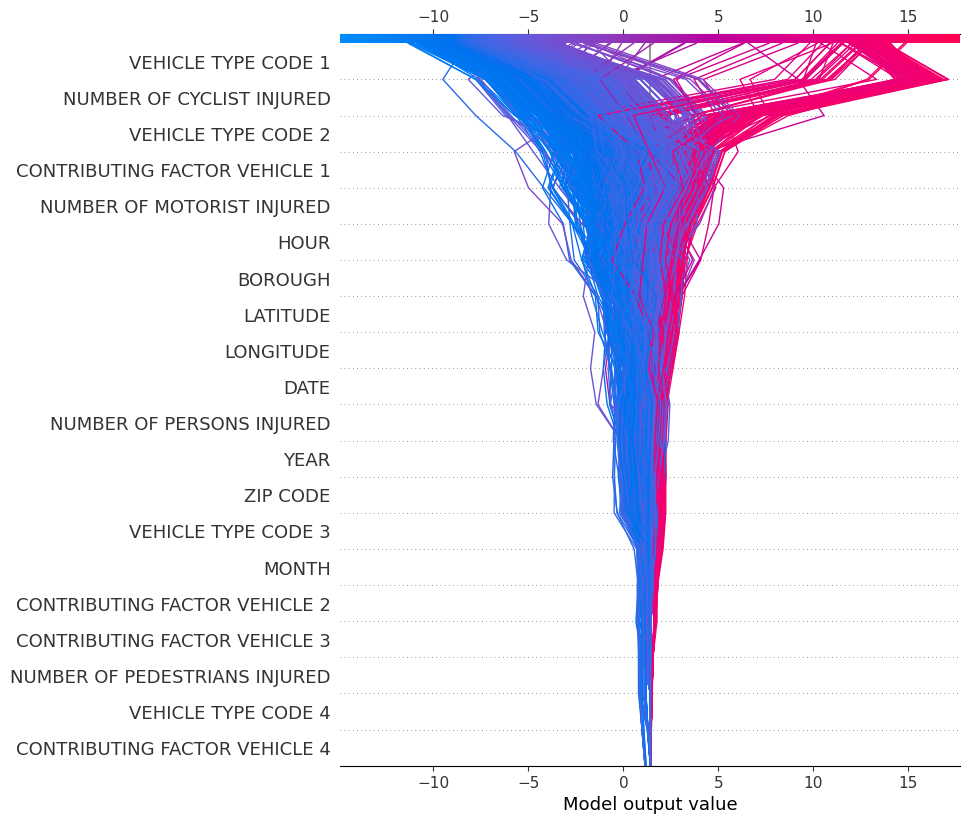

In [32]:
shap.decision_plot(explainer.expected_value[1], shap_values[:1000,:,1], feature_names=feature_names)

In [44]:
shap_values.shape

(30000, 26, 5)